In [61]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

from sleeprnn.data import utils
from sleeprnn.common import viz, constants
from sleeprnn.helpers import reader

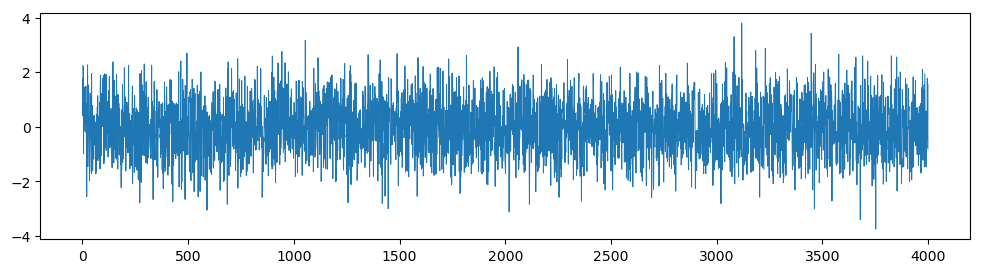

In [6]:
fs = 200
n_samples = 20 * fs

x = np.random.RandomState(seed=0).normal(size=n_samples)

plt.figure(figsize=(12, 3), dpi=100)
plt.plot(x,linewidth=0.7)
plt.show()

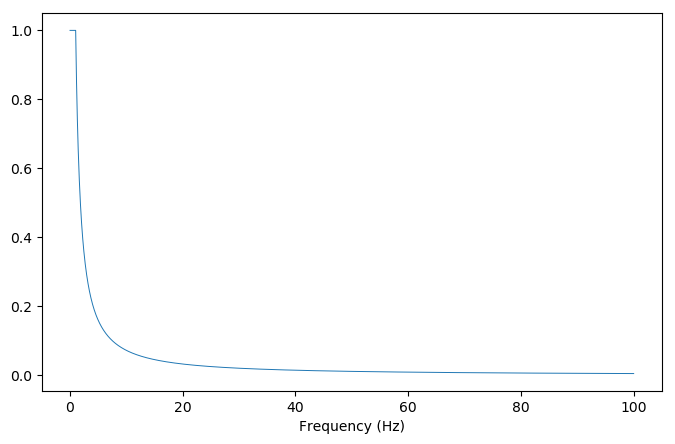

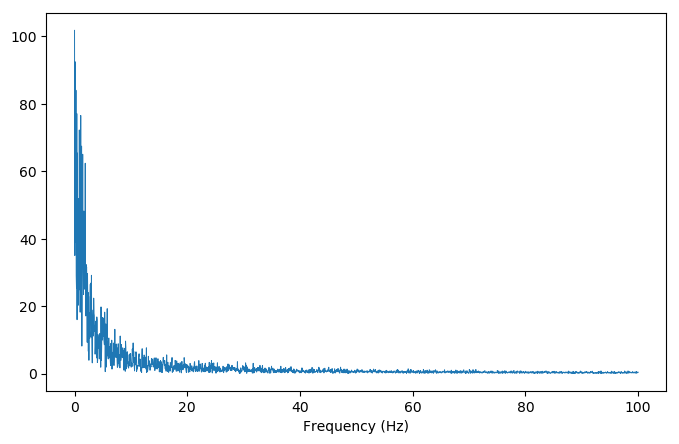

In [21]:
y = np.fft.rfft(x)
freq = np.fft.rfftfreq(x.size, d=1./fs)
freq_for_scaling = np.clip(freq, a_min=1, a_max=None)
scaling = freq_for_scaling ** (-1.14)
y = y*scaling


plt.figure(figsize=(8, 5), dpi=100)
plt.plot(freq, scaling,linewidth=0.7)
plt.xlabel("Frequency (Hz)")
plt.show()

plt.figure(figsize=(8, 5), dpi=100)
plt.plot(freq, np.abs(y),linewidth=0.7)
plt.xlabel("Frequency (Hz)")
plt.show()


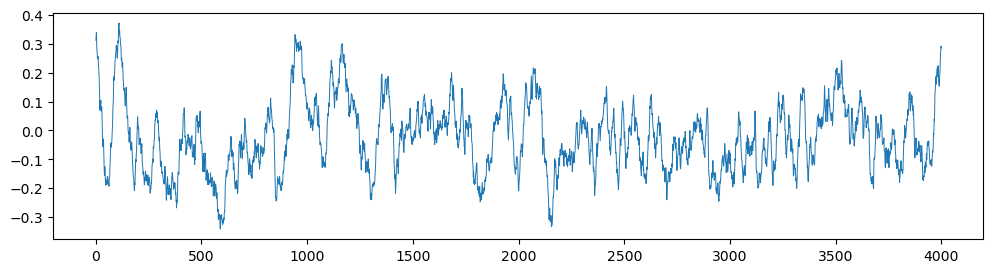

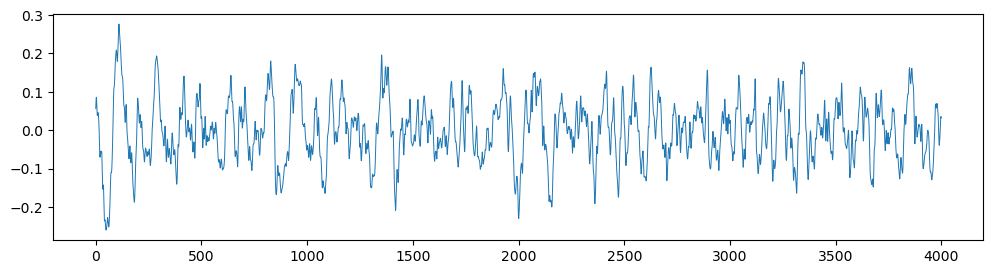

In [26]:
x_hat = np.fft.irfft(y)

x_hat_filt = utils.broad_filter(x_hat, fs, lowcut=1, highcut=30)

plt.figure(figsize=(12, 3), dpi=100)
plt.plot(x_hat,linewidth=0.7)
plt.show()

plt.figure(figsize=(12, 3), dpi=100)
plt.plot(x_hat_filt,linewidth=0.7)
plt.show()

In [27]:
def draw_spectrum(data, fs, f_min=1, f_max=30):
    y = np.fft.rfft(data)
    freq = np.fft.rfftfreq(data.size, d=1./fs)
    valid_locs = np.where((freq>=f_min) & (freq<=f_max))[0]
    freq = freq[valid_locs]
    y = y[valid_locs]
    plt.figure(figsize=(8, 5), dpi=100)
    plt.plot(freq, np.abs(y),linewidth=0.7)
    plt.xlabel("Frequency (Hz)")
    plt.show()

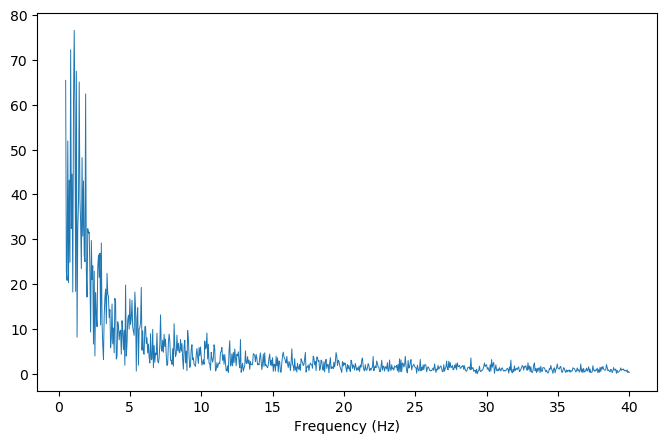

In [31]:
draw_spectrum(x_hat, fs, f_min=0.5, f_max=40)

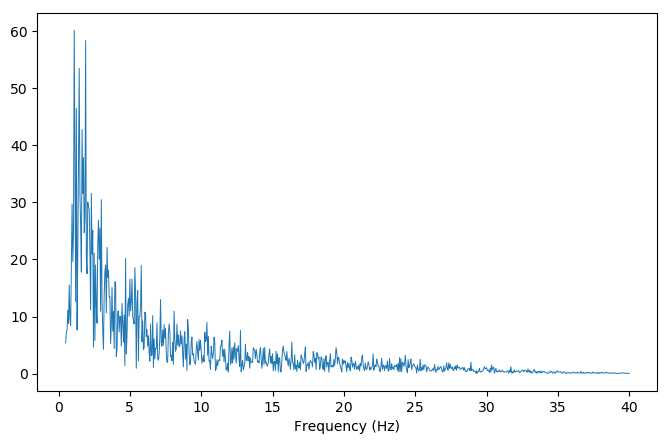

In [30]:
draw_spectrum(x_hat_filt, fs, f_min=0.5, f_max=40)

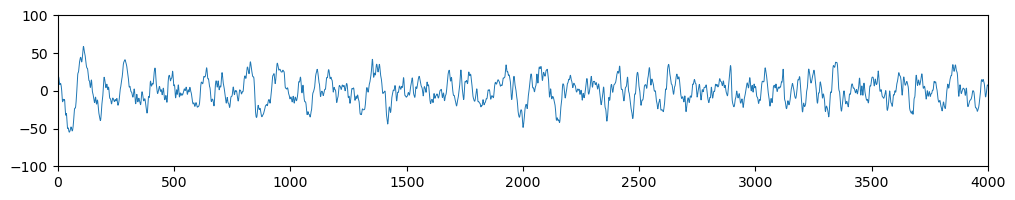

In [35]:
x_hat_filt_scaled = x_hat_filt - x_hat_filt.mean()
x_hat_filt_scaled /= x_hat_filt_scaled.std()
x_hat_filt_scaled *= 16.7

plt.figure(figsize=(12, 2), dpi=100)
plt.plot(x_hat_filt_scaled, linewidth=0.7)
plt.xlim([0, 4000])
plt.ylim([-100, 100])
plt.show()

# Many signals

In [101]:
def get_spectrum(data, fs, f_min=0, f_max=40):
    y = np.fft.rfft(data)
    freq = np.fft.rfftfreq(data.size, d=1./fs)
    valid_locs = np.where((freq>=f_min) & (freq<=f_max))[0]
    freq = freq[valid_locs]
    y = y[valid_locs]
    return freq, y


def get_mean_spectrum(data, fs, f_min=0, f_max=40):
    power_list = []
    for d in data:
        freq, y = get_spectrum(d, fs, f_min, f_max)
        power_list.append(np.abs(y))
    power_mean = np.stack(power_list, axis=0).mean(axis=0)
    return freq, power_mean

In [114]:
# mass reference
mass = reader.load_dataset(constants.MASS_SS_NAME, load_checkpoint=True, verbose=False)

In [136]:
subject_id_mass = 11
mass_signal, mass_marks = mass.get_subject_data(subject_id_mass, which_expert=1, normalize_clip=False)
freq, mean_power_mass = get_mean_spectrum(mass_signal, fs, f_min=0, f_max=100)

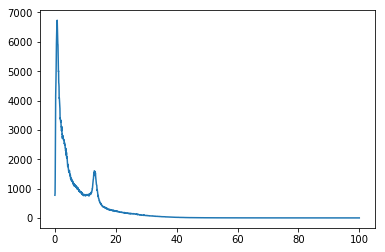

In [137]:
plt.plot(freq, mean_power_mass)
plt.show()

In [138]:
# Interpolate
from scipy import interpolate
interpolator = interpolate.interp1d(freq, mean_power_mass)
mass_power_interpolated = interpolator(freq_gen)

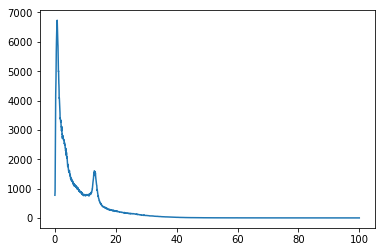

In [139]:
plt.plot(freq_gen, mass_power_interpolated)
plt.show()

In [140]:
n_pages = 500
page_size = 4000
n_padding = 2000
min_freq_to_scaling = 2
x = np.random.RandomState(seed=0).normal(size=(n_pages * page_size + 2 * n_padding))
y = np.fft.rfft(x)
freq_gen = np.fft.rfftfreq(x.size, d=1./fs)
# freq_for_scaling = np.clip(freq_gen, a_min=min_freq_to_scaling, a_max=None)
# scaling = freq_for_scaling ** (-1.14)
scaling = mass_power_interpolated / mass_power_interpolated.max()
y = y * scaling
x = np.fft.irfft(y)
# x = utils.broad_filter(x, fs, lowcut=0.3, highcut=35)
x = x[n_padding:-n_padding]
x = x - x.mean()
x = x / x.std()
x = x * 16.7
x = x.reshape((n_pages, page_size))
print(x.shape)

(500, 4000)


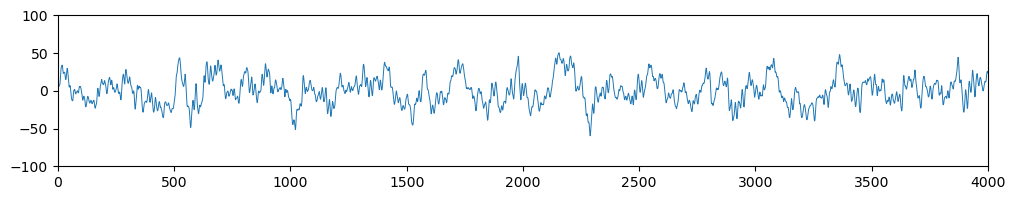

In [141]:
which_page = 100

plt.figure(figsize=(12, 2), dpi=100)
plt.plot(x[which_page], linewidth=0.7)
plt.xlim([0, 4000])
plt.ylim([-100, 100])
plt.show()

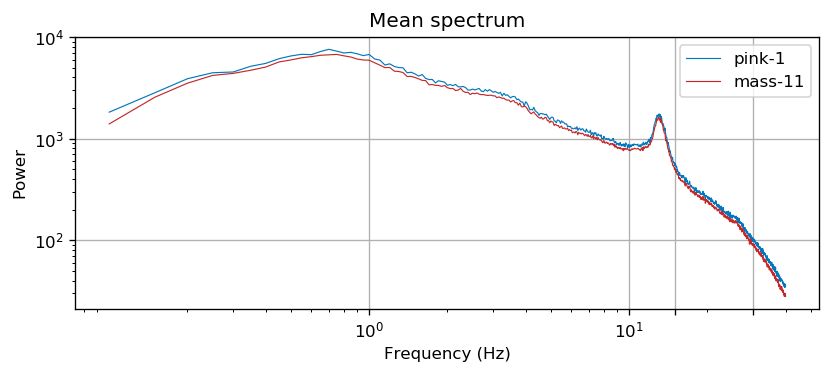

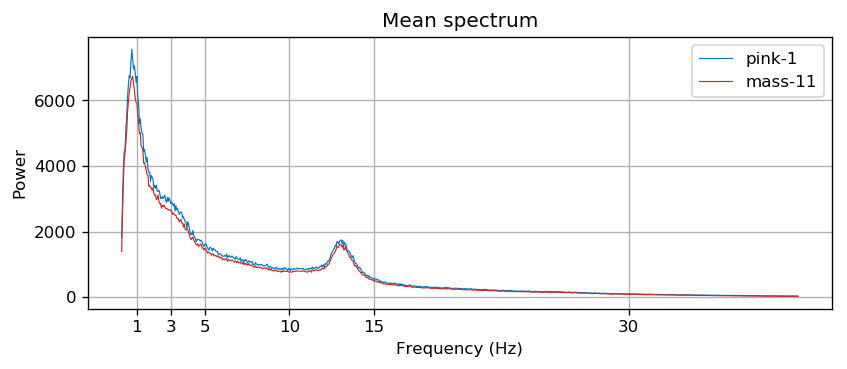

In [142]:
f_min = 0.1
f_max = 40
freq, mean_power_mass = get_mean_spectrum(mass_signal, fs, f_min=f_min, f_max=f_max)
freq, power_mean = get_mean_spectrum(x, fs, f_min=f_min, f_max=f_max)

fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=120)
ax.set_title("Mean spectrum")
ax.loglog(freq, power_mean, linewidth=0.7, label="pink-%d" % 1, color=viz.PALETTE['blue'])
ax.loglog(freq, mean_power_mass, linewidth=0.7, label="mass-%d" % subject_id_mass, color=viz.PALETTE['red'])
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power")
ax.set_xticks([1, 10, 15, 30])
ax.grid()
ax.legend()
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=120)
ax.set_title("Mean spectrum")
ax.plot(freq, power_mean, linewidth=0.7, label="pink-%d" % 1, color=viz.PALETTE['blue'])
ax.plot(freq, mean_power_mass, linewidth=0.7, label="mass-%d" % subject_id_mass, color=viz.PALETTE['red'])
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power")
ax.set_xticks([1, 3, 5, 10, 15, 30])
ax.grid()
ax.legend()
plt.show()